In [1]:
from compare_semi_supervised_clustering import *

In [2]:
from tensorflow.keras.utils import to_categorical

from ecgAI.ml.constants import *
from ecgAI.ml.algrms.ecggen.nextclip_flat import *
from ecgAI.ml.models.keras_mg.ecggen.cnntrn import *
from ecgAI.ml.train_config import train_config_get_model, TrainConfig

from actlearn.scripts.ecg_research.datasetup.ecg_data_usl_cpsc import train_config_prepare_data

config_pretrain = {
    DATA: {
        DATASETUP: "PC_C",
        ALGORITHM: NextClipXFlatPro128,
    },
    MODEL_PRETRAIN: {
        MODEL_ARCHI: CNNTransformerX,
        MODEL_MARKER: "pretrain_for_al_01",
    },

    # default parameters for pretrain
    # NOTE: actually controlled byALExperimentManagerSSAL
    PRETRAIN_DEFAULT: {
        PRETRAIN_OPT: Adam(lr=2e-4),
        PRETRAIN_KWARGS: {
            EPOCHS: 1200,
            CALLBACKS: [
                ReduceLROnPlateauKS(monitor='val_loss', factor=0.9, patience=25, mode='auto', verbose=True),
                RecordLR(),
                CorrCoef(),
            ],
        },
    },

    # default parameters for finetune
    # NOTE: actually controlled byALExperimentManagerSSAL
    FINETUNE_DEFAULT: {
        FINETUNE_OPT: Adam(lr=1e-3),
        FINETUNE_KWARGS: {
            EPOCHS: 200,
            CALLBACKS: [
                WarmUpKS(20),
                EarlyStoppingKS(monitor='val_loss', min_delta=0, patience=25, restore_best_weights=False),
                ReduceLROnPlateauKS(monitor='val_loss', factor=0.5, patience=5, verbose=False),
                RecordLR()
            ],
        },
    },
}



def load_ecg_encoding_data(categorical=False, n_samples=6000):
    train_config = TrainConfig(config_pretrain)
    data_tuple_pre, data_tuple_dtk = train_config_prepare_data(train_config)

    model = train_config_get_model(train_config, *data_tuple_pre, test_gen_dtk=data_tuple_dtk[1])

    x_train = []
    y_train = []
    for x_batch, y_batch in tqdm(data_tuple_dtk[0], desc="to_xy"):
        x_train.extend(model.encode(x_batch))
        y_train.extend(y_batch)

    x_test, y_test = data_tuple_dtk[2], data_tuple_dtk[3]
    x_test = model.encode(x_test)

    x_train = np.array(x_train)
    x_test = np.array(x_test)

    if categorical:
        # Convert class vectors to binary class matrices (one-hot encoding)
        y_train = to_categorical(y_train, 10)
        y_test = to_categorical(y_test, 10)

    if n_samples is not None and n_samples < x_train.shape[0]:
        # Randomly sample n_samples from the datasets
        train_indices = np.random.choice(x_train.shape[0], n_samples, replace=False)
        x_train = x_train[train_indices, :]
        y_train = y_train[train_indices]
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)
    return x_train, y_train, x_test, y_test


/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [3]:
    x_train, y_train, x_test, y_test = load_ecg_encoding_data()
    percentages = [0.02, 0.05, 0.1, 0.2, 0.5]
    rounds = 5

    methods = {
        "SemiSupervisedGMM": SemiSupervisedGMM,
        "LabelPropagation": LabelPropagation,
        "SVC": SVC,
        "CopKMean": CopKMean,
    }

    methods_accs = []
    for Method in tqdm(methods.values(), desc="methods"):
        accs = []  # Temporarily store accuracies for the current method
        for percentage in tqdm(percentages, desc=">> percentages"):
            # Prepare labeled and unlabeled data
            labeled_data, labeled_labels, unlabeled_data, unlabeled_labels = prepare_labeled_data(
                x_train, y_train, percentage=percentage)
            X = np.concatenate((labeled_data, unlabeled_data), axis=0)

            accs_round = []
            for _ in tqdm(range(rounds), desc="rounds"):
                model = fit_method(Method, X, labeled_data, labeled_labels, unlabeled_data, unlabeled_labels)
                cluster_assignments = model.predict(X)
                accs_round.append(clustering_accuracy(unlabeled_labels, cluster_assignments[len(labeled_labels):]))
            accs.append(accs_round)
        methods_accs.append(accs)

use default filetype as .json for the unknown source: ptb_5k


query subset ECGs: 100%|██████████| 6877/6877 [00:00<00:00, 2797151.73it/s]

before pipe:  11877
ptb_5k: 5000
cinc2020_cpsc: 6867
ptb_5k: 5000
cinc2020_cpsc: 6867
after pipe:  11867
before pipe:  6877



datagen to data:  27%|██▋       | 177/667 [00:00<00:00, 1765.51it/s]

after pipe:  6867
warning, large RAM consumption!


datagen to data: 100%|██████████| 667/667 [00:02<00:00, 237.56it/s] 
2023-11-29 23:30:47.554678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 23:30:47.631408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 23:30:47.633012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 23:30:47.679296: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To 

load model from /home/congyu/congyu_program/pythons/inits/p_ecgAI/results/trained_models/usl_model/PC_C_pro_nextclipx_cnntrx_ks_pretrain_for_al_01.ckpt.h5


to_xy:   0%|          | 0/87 [00:00<?, ?it/s]2023-11-29 23:31:15.280482: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2023-11-29 23:31:25.510767: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
to_xy: 100%|██████████| 87/87 [01:26<00:00,  1.01it/s]
2023-11-29 23:32:33.344073: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 40980480 exceeds 10% of free system memory.
>> percentages:   0%|          | 0/5 [00:00<?, ?it/s]

rounds:   0%|          | 0/5 [00:00<?, ?it/s]

rounds:  20%|██        | 1/5 [00:02<00:08,  2.20s/it]

rounds:  40%|████      | 2/5 [00:03<00:05,  1.80s/it]

rounds:  60%|██████    | 3/5 [00:03<00:03,  1.50s/it]

rounds:  80%|████████  | 4/5 [00:04<00:01,  1.31s/it]

rounds: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]

>> percentages:  20%|██        | 1/5 [00:05<00:22,  5.59s/it]

rounds:   0%|          | 0/5 [00:00<?, ?it/s]

rounds:  20%|██        | 1

rounds:  80%|████████  | 4/5 [00:13<00:03,  3.44s/it]/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


rounds: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

>> percentages:  80%|████████  | 4/5 [01:21<00:21, 21.27s/it]

rounds:   0%|          | 0/5 [00:00<?, ?it/s]/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


rounds:  20%|██        | 1/5 [00:03<00:13,  3.31s/it]/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


rounds:  40%|████      | 2/5 [00:06<00:09,  3.32s/it]/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-package

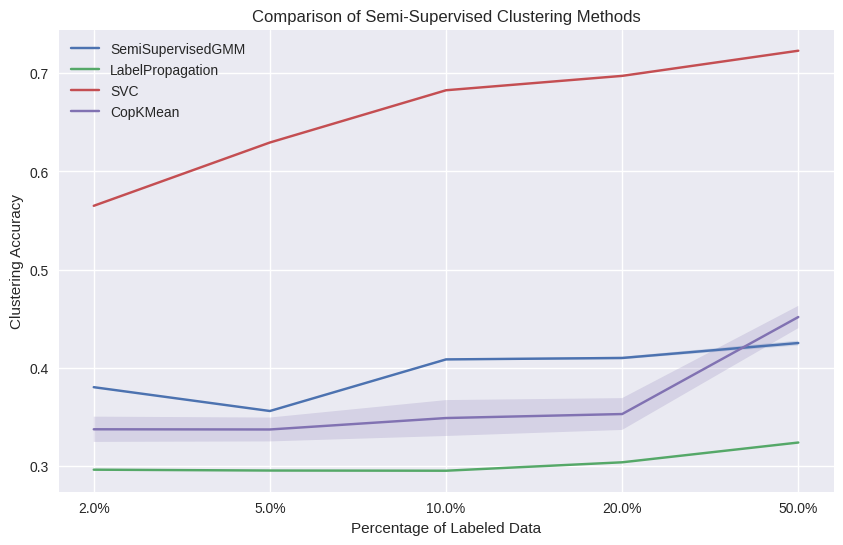

In [4]:
plot_multi_method_accs(methods_accs, percentages, methods.keys())